# Implementing Bayesian Optimization

Warning: This notebook is very computationally intensive

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, explained_variance_score

import keras

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Conv1D,MaxPooling1D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from livelossplot.tf_keras import PlotLossesCallback


In [67]:
def set_reproducible():
    np.random.seed(12345)
    random.seed(12345)
    tf.random.set_seed(12345)
    
set_reproducible()

In [68]:
dps1200 = pd.read_csv("dps1200.csv")

In [69]:
features = dps1200.iloc[:, 4:].values
labels = dps1200.iloc[:, 0].values

In [70]:
def convertToDecade(y:int) -> int: 
    return int(str(y)[:3])

def calculate_sample_weights(y_train):

    decades = [convertToDecade(year) for year in y_train]

    unique_decades, counts = np.unique(decades, return_counts=True)
    total_samples = len(y_train)
    
    weights = {}
    for decade, count in zip(unique_decades, counts):
        weights[decade] = 1 - count/total_samples

    sample_weights = []
    for year in y_train:
        sample_weights.append(weights[convertToDecade(year)])
        
    return np.array(sample_weights)
            


First redifine the model into a function where the hyperparameters are inputs. This function evaluates the model and ouptups a desired score/metric.

In [71]:
def build_model(DenseN, DropoutR, C1_K, C1_S, C2_K, C2_S, C3_K, C3_S, input_dim):

    activation1='relu'
    activation2='linear'
    
    model = keras.Sequential()
    model.add(keras.layers.Input((input_dim, 1)))
    model.add(keras.layers.GaussianNoise(0.0001))

    model.add(keras.layers.Conv1D(C1_K, (C1_S), padding='valid', activation=activation1))
    model.add(keras.layers.Conv1D(C2_K, (C2_S), padding='valid', activation=activation1))
    model.add(keras.layers.Conv1D(C3_K, (C3_S), padding='valid', activation=activation1))
    model.add(MaxPooling1D(pool_size=2))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(DropoutR))
    
    model.add(keras.layers.Dense(DenseN, activation=activation1))
    model.add(keras.layers.Dense(DenseN, activation=activation1))
    model.add(keras.layers.Dense(DenseN, activation=activation1))
    model.add(keras.layers.Dense(1, activation=activation2))

    model.compile(loss=tf.keras.losses.Huber(), optimizer=keras.optimizers.Adam(learning_rate=0.004), metrics=['mean_absolute_error'])
    
    return model


In [72]:
## Define the Huber distance (source DeepChemometrics)
def huber(y_true, y_pred, delta=1.0):
    return np.mean(delta**2*( (1+((y_true-y_pred)/delta)**2)**0.5 -1))

# Crossvalidation

Since NN training involves random sampling and weights initialization (in this case), it is usefull to use cross-validation.

In [74]:
## Compute error metrics
def error_metrices(y_true_train, y_predicted_train, y_true_test, y_predicted_test, verbose=True):
    rmse_train = np.sqrt(mean_squared_error(y_true_train, y_predicted_train))
    rmse_test = np.sqrt(mean_squared_error(y_true_test, y_predicted_test))
    R2_train= r2_score(y_true_train, y_predicted_train)
    R2_test= r2_score(y_true_test, y_predicted_test)
    hub_train = huber(y_true_train, y_predicted_train)
    hub_test = huber(y_true_test, y_predicted_test)

    if verbose:
        print('*********** Benchmark results ***********\n')
        print(f"R2    (Train/Test) = {R2_train:.3f} / {R2_test:.3f}")
        print(f"RMSE  (Train/Test) = {rmse_train:.3f} / {rmse_test:.3f}")
        print(f"Huber (Train/Test) = {hub_train:.3f} / {hub_test:.3f}")

    return (rmse_train, rmse_test, R2_train, R2_test, hub_train, hub_test)

class ModelWithData:
    def __init__(self, model, train_x, train_label, train_predicted, test_x, test_label, test_predicted, score:float, iteration) -> None:
        self.model = model
        self.train_x = train_x
        self.train_label = train_label
        self.train_predicted = train_predicted
        self.test_x = test_x
        self.test_label = test_label
        self.test_predicted = test_predicted
        self.score = score
        self.iteration = iteration

    def isBetter(self, otherScore: float) -> bool:
        return otherScore < 0 or (self.score >= 0 and self.score <= otherScore)

In [75]:

def evaluations_of_models(features, labels, DenseN, DropoutR, C1_K, C1_S, C2_K, C2_S, C3_K, C3_S, verbose=True):

    x = np.array(features)
    y = np.array(labels)
    input_dim = 410
    epochs = 1000
    
    # generate model
    model = build_model(DenseN, DropoutR, C1_K, C1_S, C2_K, C2_S, C3_K, C3_S, input_dim)

    # Define the number of Folds for Cross Validation
    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    scores_train = { "rmse": [], "r2": [], "huber": []}
    scores_test = { "rmse": [], "r2": [], "huber": []}

    if verbose:
        monitor_verbosity=1
    else:
        monitor_verbosity=0


    monitor = EarlyStopping(monitor='val_loss', min_delta=4e-5, patience=50, verbose=0, mode='auto', restore_best_weights=True)
    rdlr = ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='val_loss', verbose=monitor_verbosity)

    bestMwd = ModelWithData(None, 0, 0, 0, 0, 0, 0, -1, 0)
    
    # Iterate through the folds and train/test the model
    i = 0
    for train_index, test_index in skf.split(x, y):
        i = i + 1
        if verbose:
            print(f'\n\n> Iteration {i}')

        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Training the CNN model on X_train_fold, y_train_fold

        sample_weight=calculate_sample_weights(y_train)
        g = model.fit(x_train, y_train, epochs=epochs, batch_size=45, validation_data=(x_test, y_test), verbose=0, callbacks=[rdlr, monitor], sample_weight=sample_weight)

        # Evaluation of the model on X_test_fold, y_test_fold
        accuracy = model.evaluate(x_test, y_test, verbose=0)
        if verbose:
            print(f'Fold Accuracy: {accuracy}')

        # Analyse the error metrics

        train_pred = model.predict(x_train, verbose=0)
        test_pred = model.predict(x_test, verbose=0)

        (rmse_train, rmse_test, r2_train, r2_test, huber_train, huber_test) = error_metrices(y_train, train_pred, y_test, test_pred, verbose=verbose)

        mwd = ModelWithData(g, x_train, y_train, train_pred, x_test, y_test, test_pred, rmse_train, i)

        if mwd.isBetter(bestMwd.score):
            bestMwd = mwd

        scores_train["rmse"].append(rmse_train)
        scores_train["r2"].append(r2_train)
        scores_train["huber"].append(huber_train)

        scores_test["rmse"].append(rmse_test)
        scores_test["r2"].append(r2_test)
        scores_test["huber"].append(huber_test)

    ## clear session 
    tf.keras.backend.clear_session()

    scores_train_mean = {}
    scores_test_mean = {}
    num_model = len(scores_train["rmse"])

    for metric in scores_train.keys():
        scores_train_mean[metric] = np.mean(scores_train[metric])
        scores_test_mean[metric] = np.mean(scores_test[metric])
        if verbose:
            print(f'Train: {metric} (mean of {num_model} models)= {scores_train_mean[metric]} \nTest: {metric} (mean of {num_model} models)= {scores_test_mean[metric]}')

    return (bestMwd, scores_train_mean, scores_test_mean)

# Optimization

In [76]:
# Libraries
import GPy, GPyOpt

In [77]:
## Range of parameters used by Bjerrum et al. 2017
dense_range=np.arange(4,720,1)
c1_k_range=np.arange(2,64,1)
c1_s_range=np.arange(1,64,1)
c2_k_range=np.arange(2,64,1)
c2_s_range=np.arange(1,64,1)
c3_k_range=np.arange(2,64,1)
c3_s_range=np.arange(1,64,1)

# bounds for hyperparameters in the model
bounds = [{'name': 'DenseN',   'type': 'discrete',  'domain': dense_range},
          {'name': 'DropoutR', 'type': 'continuous',  'domain': (0.0, 0.5)},
          {'name': 'C1_K',     'type': 'discrete',  'domain': c1_k_range},
          {'name': 'C1_S',     'type': 'discrete',  'domain': c1_s_range},
          {'name': 'C2_K',     'type': 'discrete',  'domain': c2_k_range},
          {'name': 'C2_S',     'type': 'discrete',  'domain': c2_s_range},
          {'name': 'C3_K',     'type': 'discrete',  'domain': c3_k_range},
          {'name': 'C3_S',     'type': 'discrete',  'domain': c3_s_range}]

hyper_parameter_names = ["Dense Layer Neuron Count", "Dropout Rate",
                         "Convolutional Filters in Layer 1", "Convolutional Kernel Size in Layer 1",
                         "Convolutional Filters in Layer 2", "Convolutional Kernel Size in Layer 2",
                         "Convolutional Filters in Layer 3", "Convolutional Kernel Size in Layer 3"]

iter = 0


In [78]:
train_data, test_data, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=42)

In [79]:
# function to optimize the model
def f(x):
    global iter
    iter = iter + 1
    for i in range(8):
        print(f"{hyper_parameter_names[i]}: {x[:,i]}")
    (bestMwd, scores_train_mean, scores_test_mean) = evaluations_of_models(train_data, train_labels,  
                                DenseN = int(x[:,0]), 
                                DropoutR = float(x[:,1]), 
                                C1_K=int(x[:,2]), 
                                C1_S=int(x[:,3]), 
                                C2_K=int(x[:,4]), 
                                C2_S=int(x[:,5]),
                                C3_K=int(x[:,6]), 
                                C3_S=int(x[:,7]),
                                verbose=False)
    evaluation = scores_test_mean['rmse']
    print("###############################################")
    print(f"Score of Iteration {iter}: {evaluation}")
    print("###############################################")
    return evaluation

In [80]:
## Initialize the model with 10 random hyperparameters
opt_model_gs = GPyOpt.methods.BayesianOptimization(f=f, domain=bounds, initial_design_numdata=10,verbose=1)

Dense Layer Neuron Count: [486.]
Dropout Rate: [0.45497886]
Convolutional Filters in Layer 1: [3.]
Convolutional Kernel Size in Layer 1: [51.]
Convolutional Filters in Layer 2: [41.]
Convolutional Kernel Size in Layer 2: [37.]
Convolutional Filters in Layer 3: [16.]
Convolutional Kernel Size in Layer 3: [35.]
###############################################
Score of Iteration 1: 99.16175085272755
###############################################
Dense Layer Neuron Count: [489.]
Dropout Rate: [0.4874568]
Convolutional Filters in Layer 1: [56.]
Convolutional Kernel Size in Layer 1: [10.]
Convolutional Filters in Layer 2: [25.]
Convolutional Kernel Size in Layer 2: [1.]
Convolutional Filters in Layer 3: [53.]
Convolutional Kernel Size in Layer 3: [45.]
###############################################
Score of Iteration 2: 100.275063894236
###############################################
Dense Layer Neuron Count: [289.]
Dropout Rate: [0.3280598]
Convolutional Filters in Layer 1: [51.]
Convoluti

In [81]:
iter = 0
# optimize the model over 200 iteration
opt_model_gs.run_optimization(max_iter=200)

Dense Layer Neuron Count: [216.]
Dropout Rate: [0.34579042]
Convolutional Filters in Layer 1: [45.]
Convolutional Kernel Size in Layer 1: [13.]
Convolutional Filters in Layer 2: [6.]
Convolutional Kernel Size in Layer 2: [12.]
Convolutional Filters in Layer 3: [50.]
Convolutional Kernel Size in Layer 3: [7.]
###############################################
Score of Iteration 1: 100.3538602557887
###############################################
Dense Layer Neuron Count: [294.]
Dropout Rate: [0.01003555]
Convolutional Filters in Layer 1: [38.]
Convolutional Kernel Size in Layer 1: [8.]
Convolutional Filters in Layer 2: [22.]
Convolutional Kernel Size in Layer 2: [59.]
Convolutional Filters in Layer 3: [12.]
Convolutional Kernel Size in Layer 3: [9.]
###############################################
Score of Iteration 2: 95.64933960908908
###############################################
Dense Layer Neuron Count: [294.]
Dropout Rate: [0.37389902]
Convolutional Filters in Layer 1: [30.]
Convolut

In [82]:
print("###########################")
print("Optimized Model Parameters:")
print("###########################")

for i in range(8):
      print(f"{hyper_parameter_names[i]}: {opt_model_gs.x_opt[i]}")

###########################
Optimized Model Parameters:
###########################
Dense Layer Neuron Count: 351.0
Dropout Rate: 0.0
Convolutional Filters in Layer 1: 55.0
Convolutional Kernel Size in Layer 1: 45.0
Convolutional Filters in Layer 2: 43.0
Convolutional Kernel Size in Layer 2: 36.0
Convolutional Filters in Layer 3: 63.0
Convolutional Kernel Size in Layer 3: 1.0


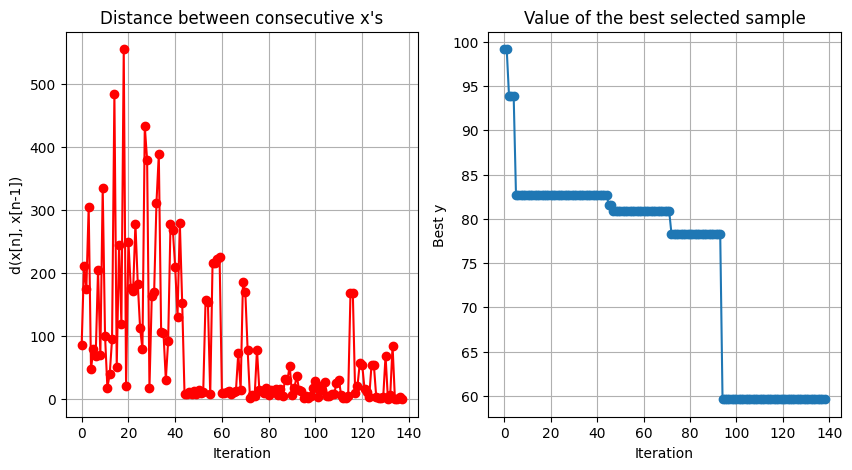

In [83]:
opt_model_gs.plot_convergence()